# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [22]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

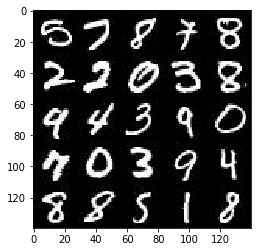

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

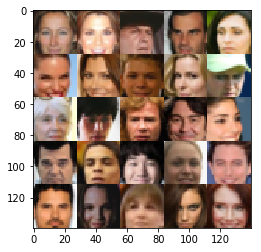

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_image')
    z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, [],'learning_rate')
    return real_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.15
    keep_prob=0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xn
        #Convolutional layer, 14x14x64
        l1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l1 = tf.maximum(alpha * l1, l1)
        l1 = tf.layers.dropout(l1, keep_prob)
        
        #A Strided convolutional layer,7x7x128
        l2 = tf.layers.conv2d(l1, 128, 5, 2, 'same', use_bias=True)
        l2 = tf.layers.batch_normalization(l2)
        l2 = tf.maximum(alpha * l2, l2)
        l2 = tf.layers.dropout(l2, keep_prob)
        
        #A Strided convolutional layer,4x4x256
        l3 = tf.layers.conv2d(l2, 256, 5, 2, 'same', use_bias=True)
        l3 = tf.layers.batch_normalization(l3)
        l3 = tf.maximum(alpha * l3, l3)
        l3 = tf.layers.dropout(l3, keep_prob)
        
        #A fully connected layer
        flat = tf.reshape(l3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.15
    keep_prob=0.7
    with tf.variable_scope('generator', reuse=(not is_train)):
        #A fully connected layer, 4x4x1024
        l1 = tf.layers.dense(z, 4*4*1024, use_bias=True)
        l1 = tf.reshape(l1, (-1, 4, 4, 1024))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        l1 = tf.layers.dropout(l1, keep_prob, training=is_train)
        
        #A Deconvolutional Layer,7x7x512
        l2 = tf.layers.conv2d_transpose(l1, 512, 4, 1, 'valid', use_bias=True)
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        l2 = tf.layers.dropout(l2, keep_prob, training=is_train)
        
        #A Deconvolutional Layer,14x14x256
        l3 = tf.layers.conv2d_transpose(l2, 256, 5, 2, 'same', use_bias=True)
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        l3 = tf.layers.dropout(l3, keep_prob, training=is_train)
        
        #The Output layer, 28x28xn
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, 2, 'same')
        
        out = tf.tanh(logits)
        #print(out.shape)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    _, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_fake = discriminator(fake, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                labels=tf.ones_like(d_logits_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_fake + d_loss_real
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_logits_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tr_vars = tf.trainable_variables()
    g_vars = [var for var in tr_vars if var.name.startswith('generator')]
    d_vars = [var for var in tr_vars if var.name.startswith('discriminator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    count = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                start_time = time.time()
                count = count + 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                sess.run(g_train_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                if count % 100 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{} Count {}...".format(epoch_i+1, epoch_count, count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g),
                      "... Time spent={:.4f}".format(time.time() - start_time))    

                if count % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Count 100... Discriminator Loss: 0.9453... Generator Loss: 1.1475 ... Time spent=0.2684
Epoch 1/2 Count 200... Discriminator Loss: 1.1227... Generator Loss: 1.0370 ... Time spent=0.2077


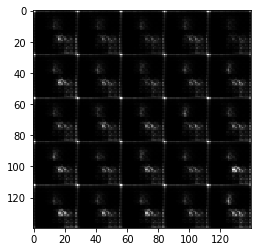

Epoch 1/2 Count 300... Discriminator Loss: 1.4235... Generator Loss: 0.6302 ... Time spent=0.2069
Epoch 1/2 Count 400... Discriminator Loss: 1.2291... Generator Loss: 0.7645 ... Time spent=0.2077


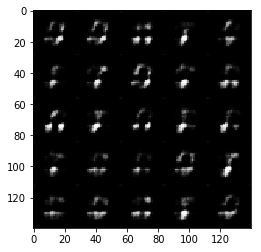

Epoch 1/2 Count 500... Discriminator Loss: 1.0316... Generator Loss: 1.0399 ... Time spent=0.2084
Epoch 1/2 Count 600... Discriminator Loss: 1.4349... Generator Loss: 0.7412 ... Time spent=0.2058


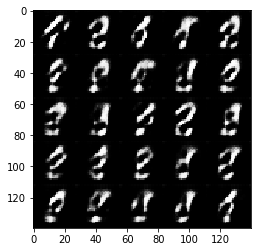

Epoch 1/2 Count 700... Discriminator Loss: 1.2071... Generator Loss: 0.8165 ... Time spent=0.2072
Epoch 1/2 Count 800... Discriminator Loss: 1.1628... Generator Loss: 1.0315 ... Time spent=0.2076


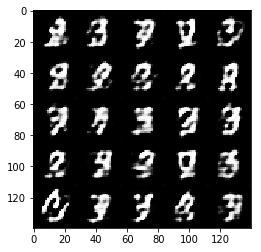

Epoch 1/2 Count 900... Discriminator Loss: 1.0582... Generator Loss: 1.2244 ... Time spent=0.2067
Epoch 1/2 Count 1000... Discriminator Loss: 0.9948... Generator Loss: 0.9755 ... Time spent=0.2084


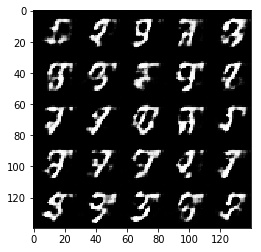

Epoch 1/2 Count 1100... Discriminator Loss: 1.1303... Generator Loss: 1.2530 ... Time spent=0.2084
Epoch 1/2 Count 1200... Discriminator Loss: 1.1075... Generator Loss: 0.9966 ... Time spent=0.2081


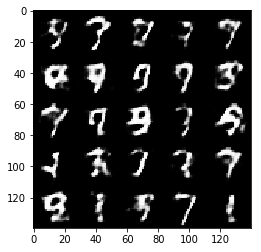

Epoch 1/2 Count 1300... Discriminator Loss: 1.1028... Generator Loss: 1.2032 ... Time spent=0.2087
Epoch 1/2 Count 1400... Discriminator Loss: 1.1207... Generator Loss: 0.9472 ... Time spent=0.2077


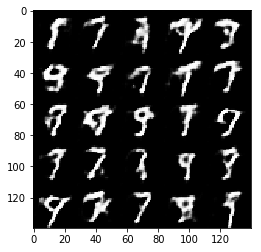

Epoch 1/2 Count 1500... Discriminator Loss: 1.2198... Generator Loss: 0.5991 ... Time spent=0.2082
Epoch 1/2 Count 1600... Discriminator Loss: 1.1490... Generator Loss: 0.8489 ... Time spent=0.2129


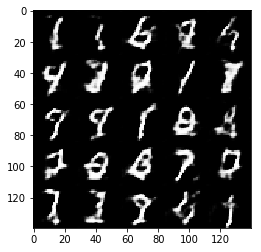

Epoch 1/2 Count 1700... Discriminator Loss: 1.1076... Generator Loss: 0.8970 ... Time spent=0.2081
Epoch 1/2 Count 1800... Discriminator Loss: 1.0401... Generator Loss: 0.7933 ... Time spent=0.2074


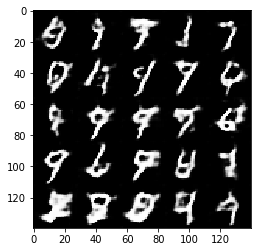

Epoch 2/2 Count 1900... Discriminator Loss: 1.1728... Generator Loss: 0.8016 ... Time spent=0.2077
Epoch 2/2 Count 2000... Discriminator Loss: 1.1476... Generator Loss: 1.0113 ... Time spent=0.2058


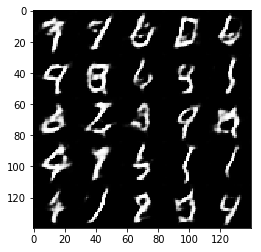

Epoch 2/2 Count 2100... Discriminator Loss: 1.1094... Generator Loss: 1.2274 ... Time spent=0.2046
Epoch 2/2 Count 2200... Discriminator Loss: 1.1424... Generator Loss: 0.7835 ... Time spent=0.2073


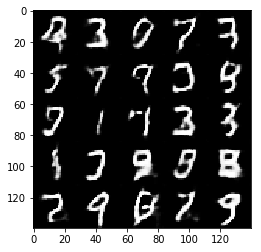

Epoch 2/2 Count 2300... Discriminator Loss: 1.1556... Generator Loss: 1.1747 ... Time spent=0.2064
Epoch 2/2 Count 2400... Discriminator Loss: 1.1339... Generator Loss: 0.8688 ... Time spent=0.2067


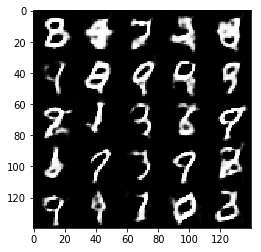

Epoch 2/2 Count 2500... Discriminator Loss: 1.1117... Generator Loss: 0.8457 ... Time spent=0.2102
Epoch 2/2 Count 2600... Discriminator Loss: 1.2373... Generator Loss: 0.8388 ... Time spent=0.2075


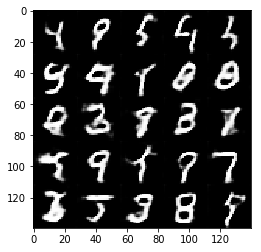

Epoch 2/2 Count 2700... Discriminator Loss: 1.1782... Generator Loss: 0.8655 ... Time spent=0.2081
Epoch 2/2 Count 2800... Discriminator Loss: 1.0459... Generator Loss: 0.9624 ... Time spent=0.2092


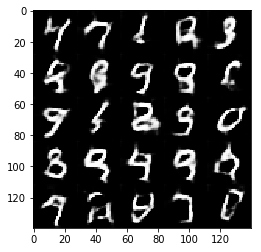

Epoch 2/2 Count 2900... Discriminator Loss: 1.0295... Generator Loss: 1.1074 ... Time spent=0.2056
Epoch 2/2 Count 3000... Discriminator Loss: 1.0508... Generator Loss: 1.0742 ... Time spent=0.2062


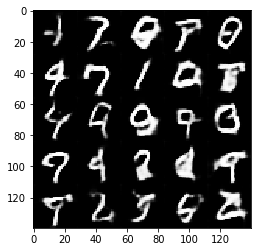

Epoch 2/2 Count 3100... Discriminator Loss: 1.1403... Generator Loss: 1.1367 ... Time spent=0.2076
Epoch 2/2 Count 3200... Discriminator Loss: 1.1075... Generator Loss: 1.1396 ... Time spent=0.2065


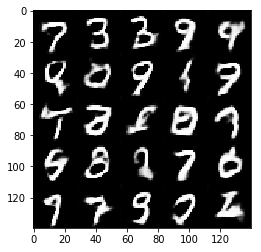

Epoch 2/2 Count 3300... Discriminator Loss: 1.0940... Generator Loss: 1.0787 ... Time spent=0.2075
Epoch 2/2 Count 3400... Discriminator Loss: 1.1893... Generator Loss: 1.3216 ... Time spent=0.2074


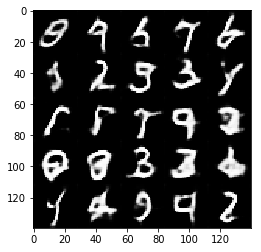

Epoch 2/2 Count 3500... Discriminator Loss: 1.0564... Generator Loss: 0.8847 ... Time spent=0.2080
Epoch 2/2 Count 3600... Discriminator Loss: 1.0304... Generator Loss: 1.0077 ... Time spent=0.2091


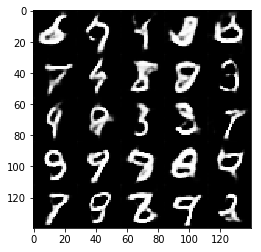

Epoch 2/2 Count 3700... Discriminator Loss: 1.0649... Generator Loss: 1.2258 ... Time spent=0.2100


In [33]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Count 100... Discriminator Loss: 0.8372... Generator Loss: 1.7053 ... Time spent=0.1936
Epoch 1/1 Count 200... Discriminator Loss: 0.9964... Generator Loss: 1.0706 ... Time spent=0.1324


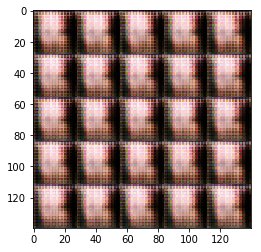

Epoch 1/1 Count 300... Discriminator Loss: 0.8372... Generator Loss: 1.4257 ... Time spent=0.1331
Epoch 1/1 Count 400... Discriminator Loss: 0.7666... Generator Loss: 1.6377 ... Time spent=0.1323


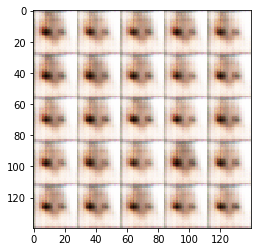

Epoch 1/1 Count 500... Discriminator Loss: 1.0076... Generator Loss: 1.2205 ... Time spent=0.1308
Epoch 1/1 Count 600... Discriminator Loss: 1.1973... Generator Loss: 0.6424 ... Time spent=0.1333


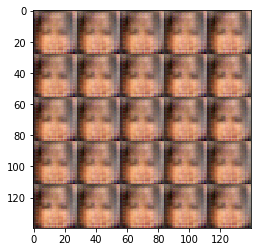

Epoch 1/1 Count 700... Discriminator Loss: 0.8888... Generator Loss: 1.3044 ... Time spent=0.1332
Epoch 1/1 Count 800... Discriminator Loss: 1.3348... Generator Loss: 0.6874 ... Time spent=0.1327


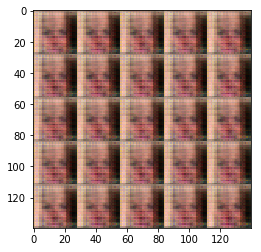

Epoch 1/1 Count 900... Discriminator Loss: 1.4506... Generator Loss: 0.6483 ... Time spent=0.1339
Epoch 1/1 Count 1000... Discriminator Loss: 0.8413... Generator Loss: 1.2751 ... Time spent=0.1321


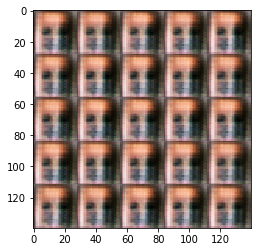

Epoch 1/1 Count 1100... Discriminator Loss: 1.2478... Generator Loss: 0.7858 ... Time spent=0.1314
Epoch 1/1 Count 1200... Discriminator Loss: 0.9563... Generator Loss: 1.2728 ... Time spent=0.1316


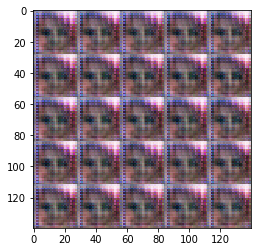

Epoch 1/1 Count 1300... Discriminator Loss: 1.1535... Generator Loss: 0.7712 ... Time spent=0.1312
Epoch 1/1 Count 1400... Discriminator Loss: 1.1126... Generator Loss: 1.0519 ... Time spent=0.1323


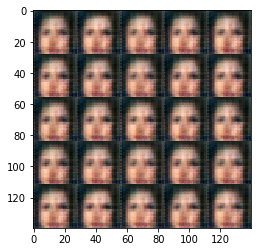

Epoch 1/1 Count 1500... Discriminator Loss: 1.0961... Generator Loss: 0.8922 ... Time spent=0.1324
Epoch 1/1 Count 1600... Discriminator Loss: 1.2465... Generator Loss: 0.8673 ... Time spent=0.1343


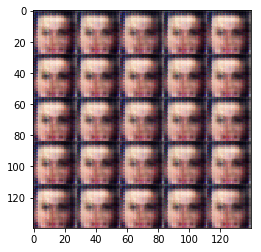

Epoch 1/1 Count 1700... Discriminator Loss: 0.9564... Generator Loss: 1.1155 ... Time spent=0.1311
Epoch 1/1 Count 1800... Discriminator Loss: 0.8582... Generator Loss: 1.4805 ... Time spent=0.1319


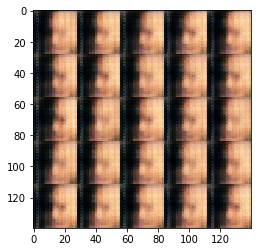

Epoch 1/1 Count 1900... Discriminator Loss: 1.2549... Generator Loss: 0.8299 ... Time spent=0.1325
Epoch 1/1 Count 2000... Discriminator Loss: 0.9517... Generator Loss: 1.1513 ... Time spent=0.1309


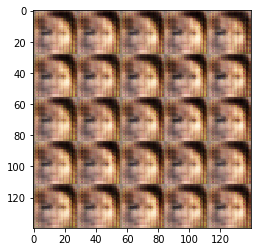

Epoch 1/1 Count 2100... Discriminator Loss: 1.0188... Generator Loss: 1.1477 ... Time spent=0.1329
Epoch 1/1 Count 2200... Discriminator Loss: 1.2767... Generator Loss: 0.6897 ... Time spent=0.1313


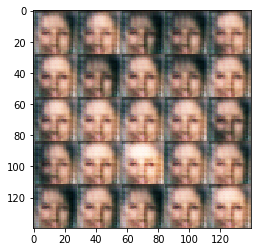

Epoch 1/1 Count 2300... Discriminator Loss: 1.1073... Generator Loss: 0.9132 ... Time spent=0.1309
Epoch 1/1 Count 2400... Discriminator Loss: 1.3068... Generator Loss: 0.7049 ... Time spent=0.1325


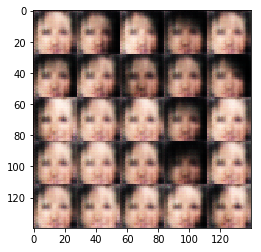

Epoch 1/1 Count 2500... Discriminator Loss: 1.1509... Generator Loss: 0.7383 ... Time spent=0.1323
Epoch 1/1 Count 2600... Discriminator Loss: 1.0231... Generator Loss: 0.9799 ... Time spent=0.1332


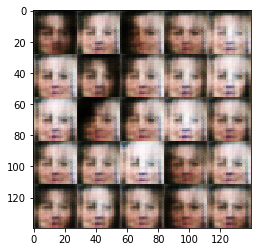

Epoch 1/1 Count 2700... Discriminator Loss: 1.1031... Generator Loss: 0.9958 ... Time spent=0.1317
Epoch 1/1 Count 2800... Discriminator Loss: 1.3807... Generator Loss: 0.7069 ... Time spent=0.1318


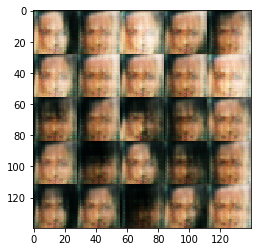

Epoch 1/1 Count 2900... Discriminator Loss: 1.0784... Generator Loss: 0.9570 ... Time spent=0.1310
Epoch 1/1 Count 3000... Discriminator Loss: 1.1747... Generator Loss: 0.7980 ... Time spent=0.1319


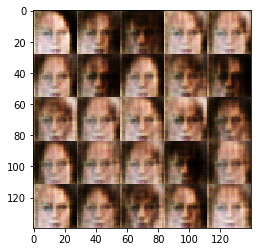

Epoch 1/1 Count 3100... Discriminator Loss: 1.3878... Generator Loss: 0.5980 ... Time spent=0.1343
Epoch 1/1 Count 3200... Discriminator Loss: 1.2469... Generator Loss: 0.6574 ... Time spent=0.1334


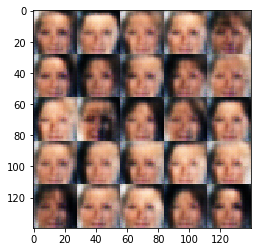

Epoch 1/1 Count 3300... Discriminator Loss: 1.3901... Generator Loss: 0.5960 ... Time spent=0.1311
Epoch 1/1 Count 3400... Discriminator Loss: 1.2722... Generator Loss: 0.6808 ... Time spent=0.1330


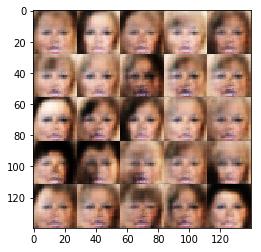

Epoch 1/1 Count 3500... Discriminator Loss: 1.2558... Generator Loss: 0.7246 ... Time spent=0.1309
Epoch 1/1 Count 3600... Discriminator Loss: 1.3845... Generator Loss: 0.6805 ... Time spent=0.1330


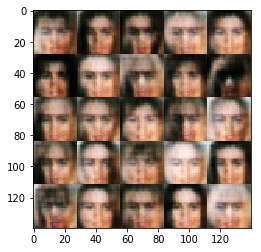

Epoch 1/1 Count 3700... Discriminator Loss: 1.3009... Generator Loss: 0.7051 ... Time spent=0.1315
Epoch 1/1 Count 3800... Discriminator Loss: 1.3450... Generator Loss: 0.5737 ... Time spent=0.1319


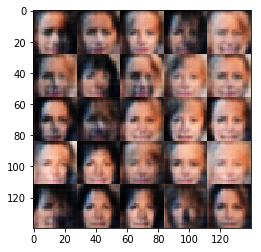

Epoch 1/1 Count 3900... Discriminator Loss: 1.3190... Generator Loss: 0.6635 ... Time spent=0.1329
Epoch 1/1 Count 4000... Discriminator Loss: 1.0866... Generator Loss: 0.8841 ... Time spent=0.1328


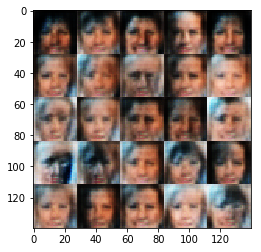

Epoch 1/1 Count 4100... Discriminator Loss: 1.2692... Generator Loss: 0.7608 ... Time spent=0.1326
Epoch 1/1 Count 4200... Discriminator Loss: 1.3285... Generator Loss: 0.6661 ... Time spent=0.1327


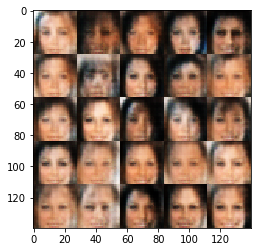

Epoch 1/1 Count 4300... Discriminator Loss: 1.2170... Generator Loss: 0.7670 ... Time spent=0.1326
Epoch 1/1 Count 4400... Discriminator Loss: 1.3372... Generator Loss: 0.6057 ... Time spent=0.1331


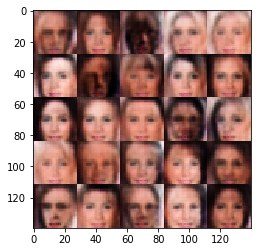

Epoch 1/1 Count 4500... Discriminator Loss: 1.3739... Generator Loss: 0.6785 ... Time spent=0.1342
Epoch 1/1 Count 4600... Discriminator Loss: 1.2542... Generator Loss: 0.7941 ... Time spent=0.1333


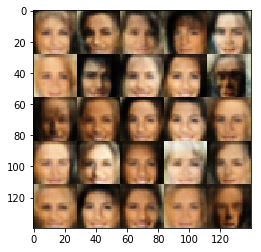

Epoch 1/1 Count 4700... Discriminator Loss: 1.1313... Generator Loss: 0.8389 ... Time spent=0.1340
Epoch 1/1 Count 4800... Discriminator Loss: 1.1855... Generator Loss: 0.7845 ... Time spent=0.1325


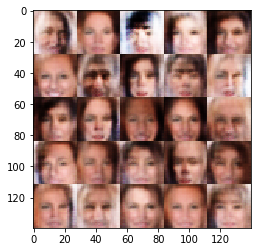

Epoch 1/1 Count 4900... Discriminator Loss: 1.2465... Generator Loss: 0.7638 ... Time spent=0.1333
Epoch 1/1 Count 5000... Discriminator Loss: 1.3824... Generator Loss: 0.6364 ... Time spent=0.1315


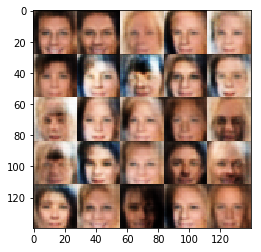

Epoch 1/1 Count 5100... Discriminator Loss: 1.2545... Generator Loss: 0.8161 ... Time spent=0.1309
Epoch 1/1 Count 5200... Discriminator Loss: 1.2386... Generator Loss: 0.7811 ... Time spent=0.1317


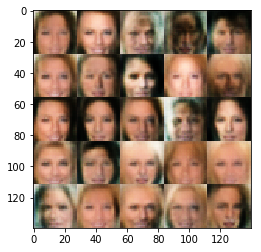

Epoch 1/1 Count 5300... Discriminator Loss: 1.3441... Generator Loss: 0.7242 ... Time spent=0.1330
Epoch 1/1 Count 5400... Discriminator Loss: 1.2507... Generator Loss: 0.7782 ... Time spent=0.1331


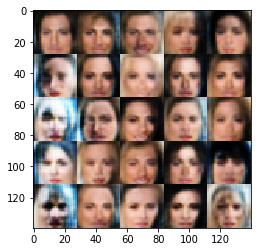

Epoch 1/1 Count 5500... Discriminator Loss: 1.2707... Generator Loss: 0.5921 ... Time spent=0.1312
Epoch 1/1 Count 5600... Discriminator Loss: 1.2131... Generator Loss: 0.8972 ... Time spent=0.1328


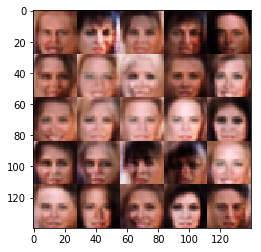

Epoch 1/1 Count 5700... Discriminator Loss: 1.1065... Generator Loss: 0.9165 ... Time spent=0.1332
Epoch 1/1 Count 5800... Discriminator Loss: 1.1311... Generator Loss: 1.0125 ... Time spent=0.1315


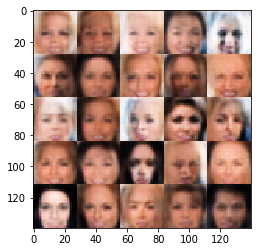

Epoch 1/1 Count 5900... Discriminator Loss: 1.3034... Generator Loss: 0.7530 ... Time spent=0.1312
Epoch 1/1 Count 6000... Discriminator Loss: 1.1543... Generator Loss: 0.7617 ... Time spent=0.1312


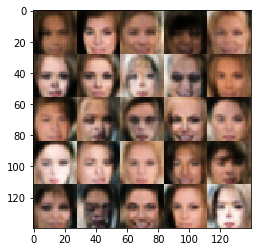

Epoch 1/1 Count 6100... Discriminator Loss: 1.1458... Generator Loss: 0.8292 ... Time spent=0.1328
Epoch 1/1 Count 6200... Discriminator Loss: 1.2019... Generator Loss: 0.8283 ... Time spent=0.1324


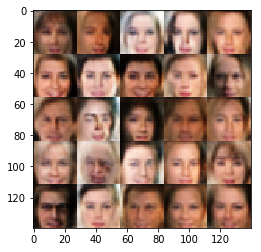

Epoch 1/1 Count 6300... Discriminator Loss: 1.2874... Generator Loss: 0.8052 ... Time spent=0.1318
Epoch 1/1 Count 6400... Discriminator Loss: 1.1081... Generator Loss: 0.8886 ... Time spent=0.1316


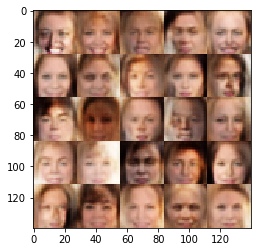

Epoch 1/1 Count 6500... Discriminator Loss: 1.2811... Generator Loss: 0.6404 ... Time spent=0.1349
Epoch 1/1 Count 6600... Discriminator Loss: 1.2030... Generator Loss: 0.7979 ... Time spent=0.1326


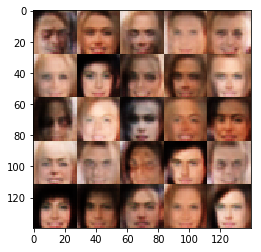

Epoch 1/1 Count 6700... Discriminator Loss: 1.1635... Generator Loss: 1.0166 ... Time spent=0.1314
Epoch 1/1 Count 6800... Discriminator Loss: 1.1776... Generator Loss: 0.8882 ... Time spent=0.1321


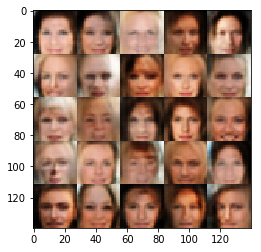

Epoch 1/1 Count 6900... Discriminator Loss: 1.0652... Generator Loss: 0.9604 ... Time spent=0.1317
Epoch 1/1 Count 7000... Discriminator Loss: 1.1553... Generator Loss: 0.9276 ... Time spent=0.1316


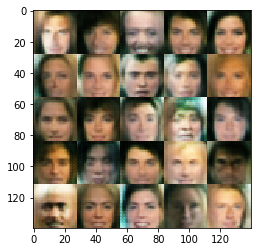

Epoch 1/1 Count 7100... Discriminator Loss: 1.0609... Generator Loss: 1.1409 ... Time spent=0.1324
Epoch 1/1 Count 7200... Discriminator Loss: 1.1276... Generator Loss: 0.9580 ... Time spent=0.1326


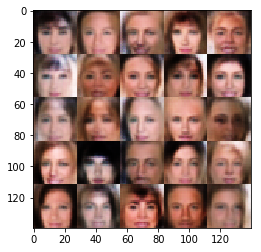

Epoch 1/1 Count 7300... Discriminator Loss: 1.1623... Generator Loss: 0.7877 ... Time spent=0.1340
Epoch 1/1 Count 7400... Discriminator Loss: 1.2697... Generator Loss: 0.6673 ... Time spent=0.1339


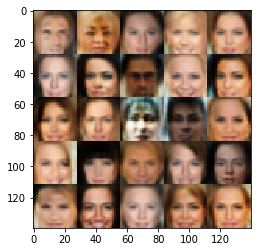

KeyboardInterrupt: 

In [34]:
batch_size = 16
z_dim = 128
learning_rate = 0.0001
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.